### The shap_values object 
is a list with two arrays. The first array is the SHAP values for a negative outcome, and the second array is the list of SHAP values for the positive outcome. We typically think about predictions in terms of the prediction of a positive outcome, so we'll pull out SHAP values for positive outcomes (**pulling out shap_values[1]**)

In [1]:
import shap
# Load kedro environment (not needed in .py)
from pathlib import Path
from kedro.framework.context import load_context

# Load a context to be able to work in the notebook
current_dir = Path("/u01/share/cesar/aa_engine_uy/notebooks_uy/shap")
proj_path = current_dir.parent.parent
context = load_context(proj_path)
catalog = context.catalog
credentials = context.config_loader.get("credentials*","credentials*/**")
parameters = context.config_loader.get("parameters*","parameters*/**")
from re import search
from aa_engine_pkg.assets.utils import *

from datetime import datetime
from scipy.ndimage import gaussian_filter1d
import os
from lime.lime_tabular import LimeTabularExplainer
import shap
import numpy as np
import pandas as pd
import re
import plotly.graph_objects as go
import math
import seaborn as sns
import waterfall_chart


from aa_engine_pkg.assets.utils import *
pd.set_option('display.max_columns', 100)

# Initialize logger
log = logging.getLogger(__name__)

In [2]:
# Loading parameters
model = "pwb"
model_type = "binary"
if model == "":
    model = parameters["models"]["model"]
if model_type == "":
    model = parameters["models"][model]["model_type"]
id_var = parameters["models"][model][model_type]["id_vars"]
period_var = parameters["models"][model][model_type]["period_vars"]
score_var = parameters["models"][model][model_type]["score_var"]

In [24]:
def load_explainability_input(model:str,
                              model_type:str,
                              parameters):

    # Load parameters
    model_path = parameters["paths"]["model_path"]
    n_threads = parameters["models"]["n_threads"]
    target_var = parameters["models"][model][model_type]["target_var"]
    score_var = parameters["models"][model][model_type]["score_var"]
    fill_na_with = parameters["models"][model][model_type]["fill_na_with"]
    model_format = parameters["models"][model][model_type]["model_to_load"]
    print(model_path + model_format + f"_{model}_{model_type}_model/")
    if type(fill_na_with) == str:
        fill_na_with = eval(fill_na_with)

    # Set model file
    model_folder = model_path + model_format + f"_{model}_{model_type}_model/"

    # Load model
    lgbmodel = lgbm.Booster(model_file=model_folder + model_format + ".txt")

    # Load data
    aux = pd.read_csv(model_folder + model_format + "_volumes.csv", sep=";", decimal=",")
    periods_to_load = aux.loc[aux["SET"]=="TRAIN",period_var[0]].astype(str).unique().tolist()
    if model != "pwb":
        df = load_and_merge_tables(model=model,
                               model_type=model_type,
                               periods=periods_to_load,
                               parameters=parameters,
                               load_subsample=False,
                               load_target=True)
    else:
        df = load_and_merge_tables_unactive_clients(model=model,
                      model_type=model_type,
                      target_periods=periods_to_load,
                      parameters=parameters,
                      load_subsample=False,
                      load_target=True)
    print(df.shape)

    df = add_selected_variables(df, lgbmodel.feature_name(), fill_na_with)
    df=df[lgbmodel.feature_name()].copy()
    
    df[score_var] = lgbmodel.predict(df)
    df.sort_values(score_var, inplace=True)

    # Return lime input
    return lgbmodel, df

In [4]:
def generate_output_dependence_plot(shap_values ,x_train, number_of_top_variables,sample_size,path=None):
    
    vars_=[var for var in df.columns if var not in ["SCORE"]]
    x_train = df.loc[:,vars_].sample(sample_size,random_state=42)
    top_inds = np.argsort(-np.sum(np.abs(np.array(shap_values)), 0))
    
    for i in np.arange(0, number_of_top_variables):
        variable_selected = x_train.columns[top_inds[i]]
        print('Iterating SHAP values for variable {}'.format(variable_selected))
        index_ = x_train[variable_selected] <= x_train[variable_selected].quantile(0.95)
        train=x_train.loc[index_]
        shap_=shap_values[np.where(index_)]
        shap.dependence_plot(variable_selected,shap_values[x_train.index],x_train,feature_names=train.columns,xmax="percentile(0.95)",interaction_index=None,show=False)
        plt.title("{} plot".format(variable_selected))
        plt.ylabel("Score contribution for the \n {} feature".format(variable_selected))
        aux_dt = pd.DataFrame({'variable_value':x_train[variable_selected].values,
                               'Shap':shap_values[x_train.index,np.where(np.array(x_train.columns) == variable_selected)][0]})
        aux_dt.sort_values(by='variable_value', inplace=True)
        ysmoothed = gaussian_filter1d(aux_dt['Shap'], sigma=5)
        plt.plot(aux_dt['variable_value'], ysmoothed, 'g-', linewidth=4)
        #aux_dt.to_csv(f'/u01/share/cesar/others/shap_values_curves/{variable_selected}.csv')

In [5]:
def shap_values_and_explaner(df,model_obj):
    
    # Calculate the explainer
    explainerModel = shap.TreeExplainer(model=model_obj, model_output="raw")
    explainerModel.model.original_model.params["objective"] = "binary"
    
    # Calculate the shap values
    shap_values = explainerModel.shap_values(df[model_obj.feature_name()])[1]
    # mean rate
    mean_rate = explainerModel.expected_value[1]
    
    return explainerModel,shap_values, mean_rate 

In [6]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [7]:
def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.nansum((nodes - node)**2, axis=1)
    return  np.where(dist_2==min(dist_2))

### Load data for analysis

In [25]:
lgbmodel, df = load_explainability_input(model,model_type,parameters)

/data/uy_po/models/20210610_2027_pwb_binary_model/
2021-06-11 19:44:00,043 - aa_engine_pkg.assets.utils.utilities - INFO - Loading 20200801
2021-06-11 19:44:00,058 - aa_engine_pkg.assets.utils.utilities - INFO - target rows 8129
2021-06-11 19:44:00,060 - aa_engine_pkg.assets.utils.utilities - INFO - target proportion 3.223 %
2021-06-11 19:44:00,725 - aa_engine_pkg.assets.utils.utilities - INFO - master periods to load 26


Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2021-06-11 19:44:08,426 - aa_engine_pkg.assets.utils.utilities - INFO - master table rows after join 7942
2021-06-11 19:44:08,428 - aa_engine_pkg.assets.utils.utilities - INFO - total customers 7942
2021-06-11 19:44:08,429 - aa_engine_pkg.assets.utils.utilities - INFO - target proportion 3.211 %
2021-06-11 19:44:08,430 - aa_engine_pkg.assets.utils.utilities - INFO - Loading 20200901
2021-06-11 19:44:08,447 - aa_engine_pkg.assets.utils.utilities - INFO - target rows 7992
2021-06-11 19:44:08,448 - aa_engine_pkg.assets.utils.utilities - INFO - target proportion 2.79 %
2021-06-11 19:44:09,119 - aa_engine_pkg.assets.utils.utilities - INFO - master periods to load 27
2021-06-11 19:44:17,281 - aa_engine_pkg.assets.utils.utilities - INFO - master table rows after join 7812
2021-06-11 19:44:17,283 - aa_engine_pkg.assets.utils.utilities - INFO - total customers 7812
2021-06-11 19:44:17,284 - aa_engine_pkg.assets.utils.utilities - INFO - target proportion 2.816 %
2021-06-11 19:44:17,285 - aa_engi

### Calculate, the shap values, TreeExplainer and meam risk

In [26]:
explainerModel,shap_values, mean_rate = shap_values_and_explaner(df,lgbmodel)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


### Top 10 variables Shap values vs variable values

In [27]:
vars_=[var for var in df.columns if var not in ["SCORE"]]
top_inds = np.argsort(-np.sum(np.abs(np.array(shap_values)), 0))

In [67]:
i=11
variable_selected ="EVF_BALANCE_BROUGHT_FORWARD_nanmax_5"#df.columns[top_inds[i]]
print(f'variable: {variable_selected}')

variable: EVF_BALANCE_BROUGHT_FORWARD_nanmax_5


In [68]:
aux_df = pd.DataFrame({f'{variable_selected}':df[variable_selected].values,
                       'shap_value':shap_values[:,np.where(np.array(df.columns) == variable_selected)[0][0]]})
index_ =aux_df[f'{variable_selected}'] <= aux_df[f'{variable_selected}'].quantile(0.95)
aux_df=aux_df.loc[index_].copy()
#aux_df[f'{variable_selected}'].fillna(-1,inplace=True)
smooth=aux_df.groupby([f'{variable_selected}']).agg({'shap_value':'median'}).reset_index()
smooth['shap_value_2']=smooth['shap_value'].rolling(window=50).mean()

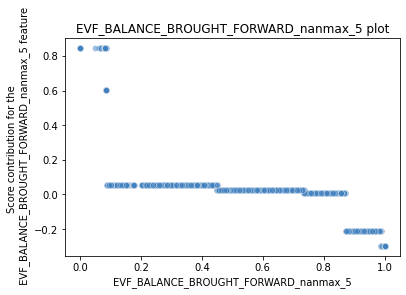

In [69]:
#ax = sns.stripplot(x=f"{variable_selected}", y="shap_value",color=(.25,.5,.75),data=aux_df,alpha=0.25)
ax=sns.scatterplot(x=f"{variable_selected}", y="shap_value",color=(.25,.5,.75),data=aux_df,alpha=0.5)
#plt.plot(smooth[f"{variable_selected}"], smooth["shap_value_2"], 'g-', linewidth=4)
plt.ylabel(f"Score contribution for the \n {variable_selected} feature")
plt.title(f"{variable_selected} plot")
path='/u01/share/cesar/others_uy/shap_values_curves/'
filename = datetime.today().strftime("%Y%m%d") + f"_SHAP_plot_{variable_selected}.png"
plt.savefig(os.path.join(path, filename),bbox_inches ='tight')

In [ ]:
print(f'Range of the score {df.SCORE.min()} {df.SCORE.max()}')

### Shap values for bucket of clientes

In [ ]:
df["ventile"]=pd.qcut(-df.SCORE,20,labels=list(range(1,21)))
df["order"]= list(range(len(df.index)))

In [ ]:
df.SCORE.hist(bins=100)
plt.axvline(df.SCORE.mean(), color = 'r', linestyle = 'dashed', linewidth = 1)
plt.title(f'Mean score value X={np.round(df.SCORE.mean(),6)}')

In [ ]:
#Best clients by ventil
best_clientes_by_ventil=df.sort_values('SCORE',ascending=False).groupby(["ventile"]).head(1)

In [ ]:
best_clientes_by_ventil.head()

In [ ]:
model_format = parameters["models"][model][model_type]["model_to_load"]
path_file_importance=f'/data/co_po/models/{model_format}_{model}_binary_model/{model_format}_important_variables.csv'

In [ ]:
shap_vals_df = pd.DataFrame(data=shap_values,columns=lgbmodel.feature_name())
df_feature = pd.read_csv(path_file_importance, sep=";", decimal=",")

In [ ]:
level=20

In [ ]:
plt.rcParams.update({'figure.figsize':(7.5,7.5), 'figure.dpi':100})
best_clientes_by_ventil=best_clientes_by_ventil.loc[best_clientes_by_ventil.ventile<=2]
factor=100
for client, ventile, shap_ix in zip(best_clientes_by_ventil.index,best_clientes_by_ventil.ventile,best_clientes_by_ventil.order):
    
    # Sigmoid transformation
    data=shap_vals_df.iloc[shap_ix]
    shap_total=data.sum()
    sigmoid_intercept = sigmoid(mean_rate)
    score = sigmoid(mean_rate + shap_total) #score = sum of all shap values+base_line 
    score_diff = score - sigmoid_intercept

    
    vars_=df_feature.iloc[0:level].column.to_list()
    shap_val_clientes=data.apply(lambda x: x / data.sum() * score_diff)
    shap_val_clientes_vars_out=shap_val_clientes.loc[[x for x in list(shap_val_clientes.index) if x not in vars_ ]]
    shap_val_clientes_vars_in=shap_val_clientes.loc[vars_]

    variables=list(shap_val_clientes_vars_in.index)
    variables.insert(0,'base level')
    variables.append('rest')
    shap=list(shap_val_clientes_vars_in.values)
    shap.insert(0,sigmoid_intercept)
    shap.append(shap_val_clientes_vars_out.sum())
    shap=[x*factor for x in shap]

    waterfall_chart.plot(variables,shap,net_label=f'score * {factor}',formatting="{:,.2f}",Title=f'Client with the best score in the ventile {ventile}', rotation_value=90);

In [ ]:
shap